In [5]:
#Functions from lesson:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import pickle
import cv2
from scipy.ndimage.measurements import label
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import time
import random
import os
def load_pickle(file):
    with open(file+".pckl", mode='rb') as f:
        return pickle.load(f)
    
def save_pickle(filename,obj):
    print("saved as", filename + ".pckl")
    with open(filename+".pckl", mode='wb') as f:
        pickle.dump(obj, f)   

def convert_color(image, color_space='RGB2YCrCb',copy=False):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif copy: 
        return np.copy(image)      
    else:
        return image


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=[True,False,False],
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
      #  if color_space != 'RGB':
      #      if color_space == 'HSV':
      #          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
      #      elif color_space == 'LUV':
      #          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
      #      elif color_space == 'HLS':
      #          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
      #      elif color_space == 'YUV':
      #          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
      #      elif color_space == 'YCrCb':
      #          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
      #  else: feature_image = np.copy(image)      
        feature_image = convert_color(image,color_space,True)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                if hog_channel[channel]:
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)  
            
#            if hog_channel == 'ALL':
#                hog_features = []
#                for channel in range(feature_image.shape[2]):
#                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                        orient, pix_per_cell, cell_per_block, 
#                                        vis=False, feature_vec=True))
#                hog_features = np.ravel(hog_features)        
#            else:
#                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
                
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel):
    
    
    box_list=[]
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)  ## WHAT HERE???
    
    imshape = ctrans_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #if hog_channel[0]:
    ch1 = ctrans_tosearch[:,:,0]
    if hog_channel[1]:
        ch2 = ctrans_tosearch[:,:,1]
    if hog_channel[2]:
        ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    if hog_channel[0]:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[1]:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[2]:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1=[]
            hog_feat2=[]
            hog_feat3=[]
            if hog_channel[0]:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[1]:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[2]:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list##draw_img, 




# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#Add a heatmap based on the boxes
def add_heat(heatmap, bbox_list,heat=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        #print(box[0][1],box[1][1], box[0][0],box[1][0])
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

#keep just the parts where we have more than one box
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def decrease_threshold(heatmap,heat=1):
    # Zero out pixels below the threshold
    heatmap[heatmap > 0] *= heat #-= heat
    heatmap[heatmap < 0] = 0
    # Return thresholded map
    return heatmap

#draw a box on label?? think this is the heatmap?
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient,pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins,color_space,hog_channel,scale = 1.5):
    images = sorted(glob.glob('test_images/test*.jpg'))
    bimages = sorted(glob.glob('test_images/btest*.jpg'))
    totalcorr=0
    for index in range(len(images)):
        image = mpimg.imread(images[index])
        bimage = mpimg.imread(bimages[index])
        draw_image = np.copy(image)
        bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
        bimage[bimage>100]=255

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        

        hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

        heatmap = np.zeros_like(image[:,:,0])
        heatmap = add_heat(heatmap, hot_windows)

        heatmap_img = apply_threshold(heatmap, 1)
        heatmap_binary=heatmap_img
        heatmap_binary[heatmap_binary>0]=255
        shape=np.shape(heatmap_binary)
        totalcorr+=sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1])

    totalcorr/=len(images)
    return totalcorr


()
data/vehicles/KITTI_extracted/3694.png


Text(0.5,1,'Not Car HOG')

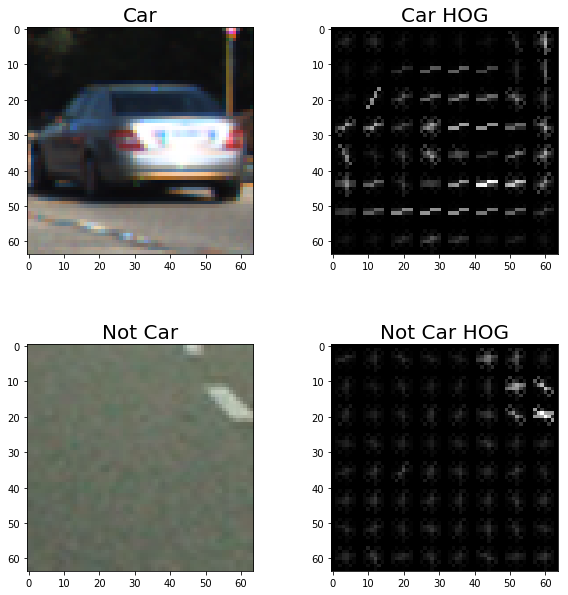

In [6]:
#Get images etc for the report
# Divide up into cars and notcars
#images = glob.glob('data/*/*/*.png')
#print(len(images))
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

#for image in images:
#    if 'GTI' in image or 'Extras' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)

carIndex=np.random.randint(len(cars))
notcarIndex=np.random.randint(len(notcars))
print(np.shape(cars[carIndex]))
print(cars[carIndex])

carExampleImage=mpimg.imread(cars[carIndex])
notExampleImage=mpimg.imread(notcars[notcarIndex])      

#Then some images and thier Hog features,

_, carhogimage = get_hog_features(carExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, nothogimage = get_hog_features(notExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carExampleImage)
ax1.set_title('Car', fontsize=20)
ax2.imshow(carhogimage, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(notExampleImage)
ax3.set_title('Not Car', fontsize=20)
ax4.imshow(nothogimage, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=20)

In [ ]:
#Get features
#Try using a Genetic algorithm or something to find this
### TODO: Tweak these parameters and see how the results change.
        
def get_feature_and_train(color_space = 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                                    orient = 11,  # HOG orientations
                                    pix_per_cell = 16, # HOG pixels per cell
                                    cell_per_block = 4, # HOG cells per block
                                    hog_channel1 = False, #2#"ALL" # Can be 0, 1, 2, or "ALL"
                                    hog_channel2 = False,
                                    hog_channel3 = True,
                                    spatial_size = (16, 16), # Spatial binning dimensions
                                    hist_bins = 16,    # Number of histogram bins
                                    spatial_feat = True, # Spatial features on or off
                                    hist_feat = True, # Histogram features on or off
                                    hog_feat = True, # HOG features on or off
                                    sample_size=-1,
                                    y_start_stop = [400,660]):# Min and max in y to search in slide_window()
                                    
    cars = glob.glob('data/vehicles/**/*.png')
    notcars = glob.glob('data/non-vehicles/**/*.png')

    hog_channel = [hog_channel1,hog_channel2,hog_channel3]
    t1=time.time()
    if sample_size > 0:
        cars=np.random.choice(cars,sample_size, replace=False)
        notcars=np.random.choice(notcars,sample_size, replace=False)

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

   # print('Using:',orient,'orientations',pix_per_cell,
   #     'pixels per cell and', cell_per_block,'cells per block')
   # print('Feature vector length:', len(X_train[0]))


    #Train classifier

    # Use a linear SVC 
    svc = LinearSVC()
    
    t2=time.time()
    svc.fit(X_train, y_train)
    t3 = time.time()
    total_time=t3-t1
    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score=svc.score(X_test, y_test)
    heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    t=time.time()
    return svc,X_scaler, score, heat_score ,total_time, t3-t2


    # Check the training time for the SVC
    #t2=time.time()
    #svc.fit(X_train, y_train)
    #t3 = time.time()
    #total_time=t3-t1
    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    #score=svc.score(X_test, y_test)
    #heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
    #                  pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    #t=time.time()
    #return score, heat_score ,total_time, t3-t2

table=[]
row=["color_space","orient","pix_per_cell","cell_per_block","hog1","hog2","hog3",
     "spatial_size","spatial_feat","hist_feat","hog_feat","score","heat_score","mean","train_time","total_time"]
table.append(row)

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel1 = False #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = False
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]
sample_size=2000
for color_space in ['HSV','YUV','HLS']:
    for orient in [11,12]:
        for pix_per_cell in [12,16]:
            for cell_per_block in [2,4]:
                for hist_bins in [16,20]:
                    for hog_channel1 in [False,True]:
                        for hog_channel2 in [False,True]:
                            for hog_channel3 in [False,True]:
                                _,_,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient,  pix_per_cell,cell_per_block, hog_channel1,hog_channel2,
                                            hog_channel3,spatial_size,  hist_bins, spatial_feat,hist_feat, hog_feat,sample_size)
                                row=[color_space,orient,pix_per_cell,cell_per_block,hog_channel1,hog_channel2,hog_channel3,
                                     spatial_size,spatial_feat,hist_feat,hog_feat,round(score, 4),round(heat_score, 4),
                                     round((score+heat_score)/2, 4),round(train_time, 4),round(total_time, 4)]
                                table.append(row)
                    print("hog done")

    print("color done")

from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [11]:
#Train with good parameters we found above!

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = True
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]
svc,X_scaler,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient, pix_per_cell,
                                    cell_per_block, hog_channel1,hog_channel2, hog_channel3,spatial_size, 
                                    hist_bins, spatial_feat,hist_feat, hog_feat)
#Now svc is a great model, so save it
print(f"score: {score}, heat score: {heat_score}, tot time: {total_time}, train time: {train_time}")


            
            
save_pickle("model",{"svc":svc,
                     "X_scaler":X_scaler,
                     "orient":orient,
                     "pix_per_cell":pix_per_cell,
                     "cell_per_block":cell_per_block,
                     "spatial_size":spatial_size,
                     "hist_bins":hist_bins,
                     "hog_channel":[hog_channel1,hog_channel2,hog_channel3]
                    })

score: 0.987331081081081, heat score: 0.9739615885416667, tot time: 88.68717432022095, train time: 6.343672275543213
saved as model.pckl


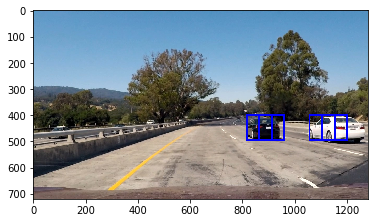

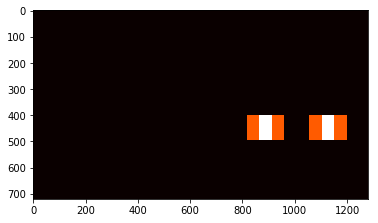

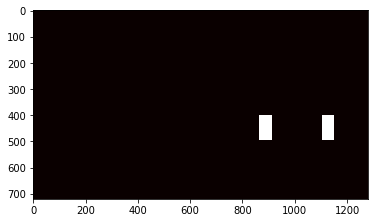

0.961203342014


In [12]:
#try the classifier with just images before video
images = sorted(glob.glob('test_images/test*.jpg'))

index=np.random.randint(len(images))
image = mpimg.imread(images[index])

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
y_start_stop = [400,660]
scale = 1.5



dist_pickle=load_pickle("model")
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]

hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()
#Do the heatmap stuff
heatmap = np.zeros_like(image[:,:,0])
heatmap = add_heat(heatmap, hot_windows)
plt.imshow(heatmap, cmap='hot')
plt.show()
heatmap_img = apply_threshold(heatmap, 1)

plt.imshow(heatmap_img, cmap='hot')
plt.show()



bimages = sorted(glob.glob('test_images/btest*.jpg'))
bimage = mpimg.imread(bimages[index])
draw_image = np.copy(image)
bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
bimage[bimage>100]=255
heatmap_binary=heatmap_img
heatmap_binary[heatmap_binary>0]=255
shape=np.shape(heatmap_binary)
print(sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1]))

In [15]:
def process_image(input_image):
    #find hot windows:
    hot_windows=find_cars(input_image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    heatmap = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heatmap, hot_windows,3)
    #somehow we should avrage the heatmap, my idea is to add to the same and let it decay, how?
    heatmap_img = apply_threshold(np.copy(heatmap),1)
    output_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6) 
    return output_img

In [16]:
video_output = 'test_videos_output/project_video_short.mp4'
video_input = VideoFileClip("project_video.mp4").subclip(20,25)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time video.write_videofile(video_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(video))

[MoviePy] >>>> Building video test_videos_output/project_video_short.mp4
[MoviePy] Writing video test_videos_output/project_video_short.mp4


 99%|█████████▉| 125/126 [00:24<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_short.mp4 

CPU times: user 23.3 s, sys: 263 ms, total: 23.5 s
Wall time: 25.7 s
